# Sentinel-2 のデータの解析と予測モデルパート

<a href="https://colab.research.google.com/github/syu-tan/Sentinel-2-Wildfire-detection/blob/main/colab/Sentinel-2_Analysis-Modeling.ipynb">
<img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab">
</a>


## `Google Colab` を使用します
ローカルで実装する場合は各自お願いします

## データの準備

 
フォルダ構成は、以下のようにファイルを配置してください。
```
data
├── 5_2
│   ├── B02_cut.jp2
│   ├── B03_cut.jp2
│   ├── B04_cut.jp2
│   └── B08_cut.jp2
├── 5_5
│   ├── B02_cut.jp2
│   ├── B03_cut.jp2
│   ├── B04_cut.jp2
│   └── B08_cut.jp2
└── fire_32653_cut.tif

2 directories, 9 files

```

In [2]:
# ファイル確認
!ls .

data  data.zip	__MACOSX  sample_data


## 環境構築
必要なライブラリーをインストール


In [4]:
!pip install -qU segmentation-models-pytorch albumentations opencv-python opencv-python seaborn tifffile

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 kB 11.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 7.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 22.9 MB/s eta 0:00:00


GPU 確認

In [5]:
!nvidia-smi

Sat May  6 10:36:21 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [6]:
import torch
print(torch.__version__)
torch.cuda.is_available()

2.0.0+cu118


True

## インポート

In [72]:
import os, glob, random, time, gc
from tqdm import tqdm

import tifffile
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import albumentations as A
from albumentations.pytorch import ToTensorV2
import segmentation_models_pytorch as smp

torch.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

## 可視化
衛星データは定性評価が一番重要です

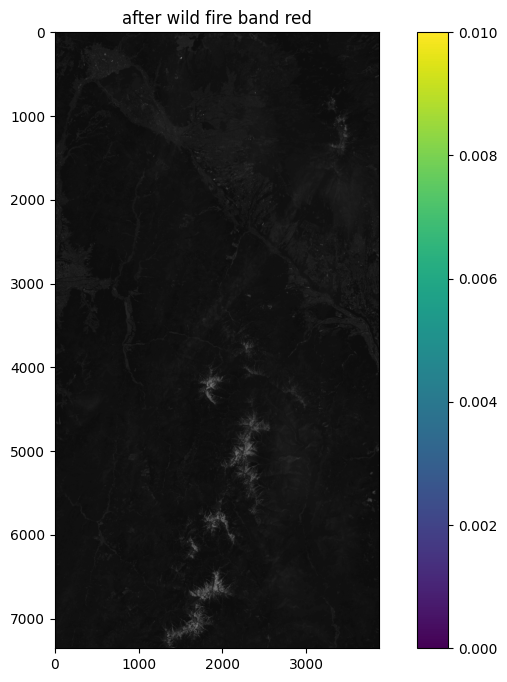

In [41]:
PATH = './data/5_5/B04_cut.jp2'
img = cv2.imread(PATH).astype(np.float32)
img = img / img.max()

plt.figure(figsize=(10, 8))
plt.title('after wild fire band red')
plt.imshow(img, 
           vmax=1e-2, 
           )
plt.colorbar()
plt.savefig('after_B04.png')
plt.show();
plt.clf()
plt.close()

del img

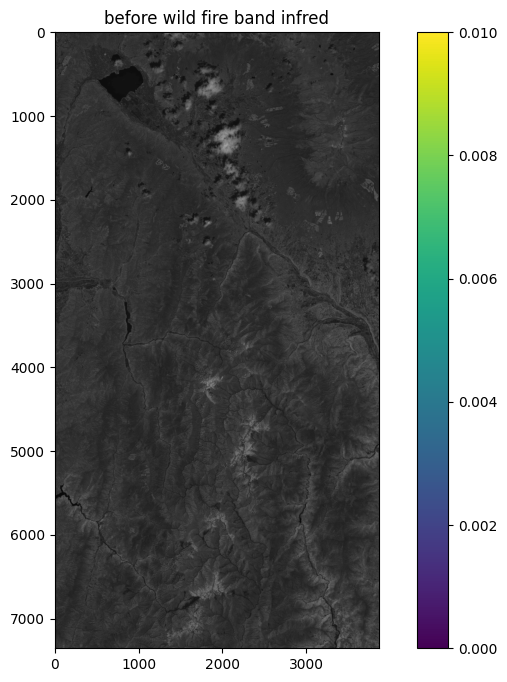

In [42]:
PATH = './data/5_2/B08_cut.jp2'
img = cv2.imread(PATH).astype(np.float32)
img = img / img.max()

plt.figure(figsize=(10, 8))
plt.title('before wild fire band infred')
plt.imshow(img, vmax=1e-2)
plt.colorbar()
plt.savefig('before_B08.png')
plt.show();
plt.clf()
plt.close()

del img

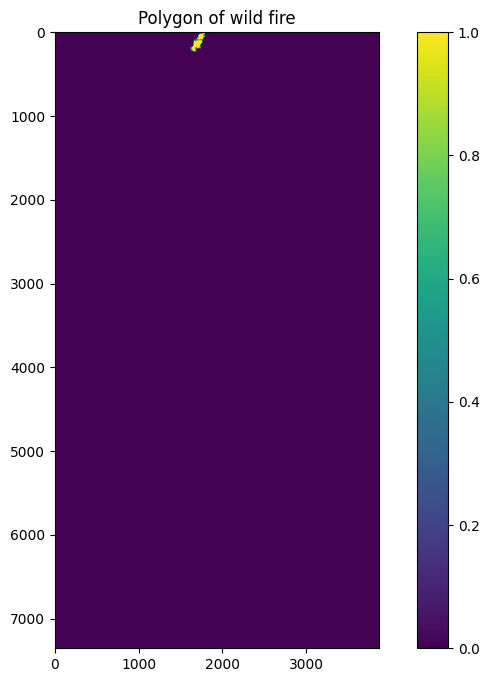

In [56]:
PATH_MASK = './data/fire_32653_cut.tif'
mask = tifffile.imread(PATH_MASK)

# 簡略化のためサイズを揃える
mask = cv2.resize(mask, (3866, 7356)) 

plt.figure(figsize=(10, 8))
plt.title('Polygon of wild fire')
plt.imshow(mask)
plt.colorbar()
plt.savefig('GT.png')
plt.show();
plt.clf()
plt.close()

## 基本解析
火事領域の特徴量の差をヒストグラムで可視化

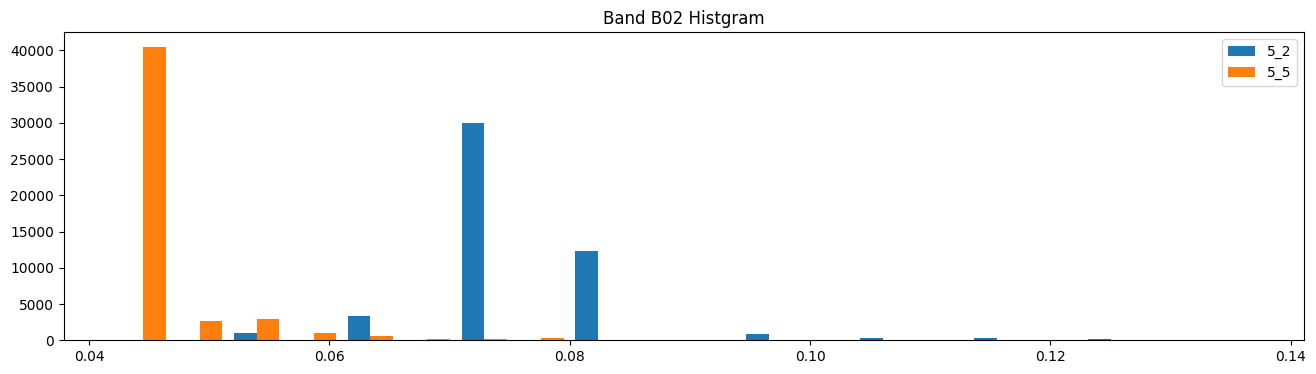

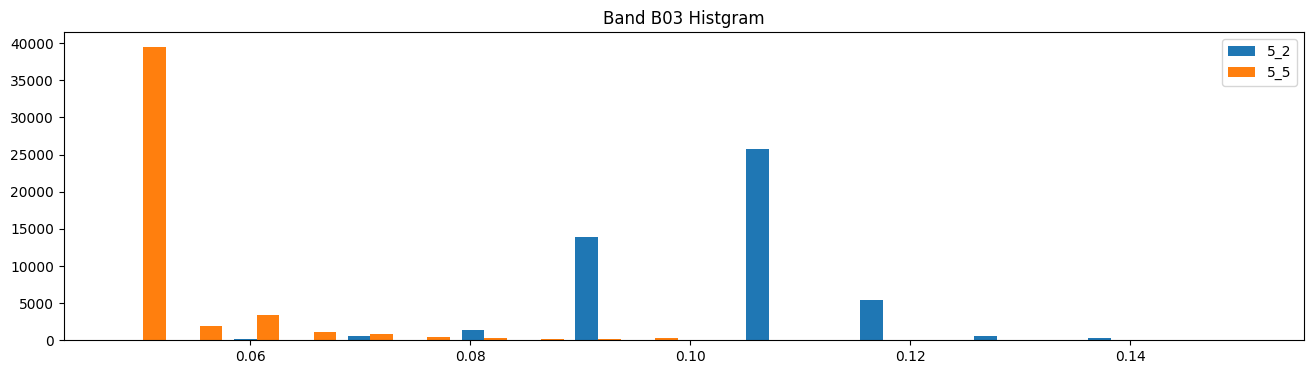

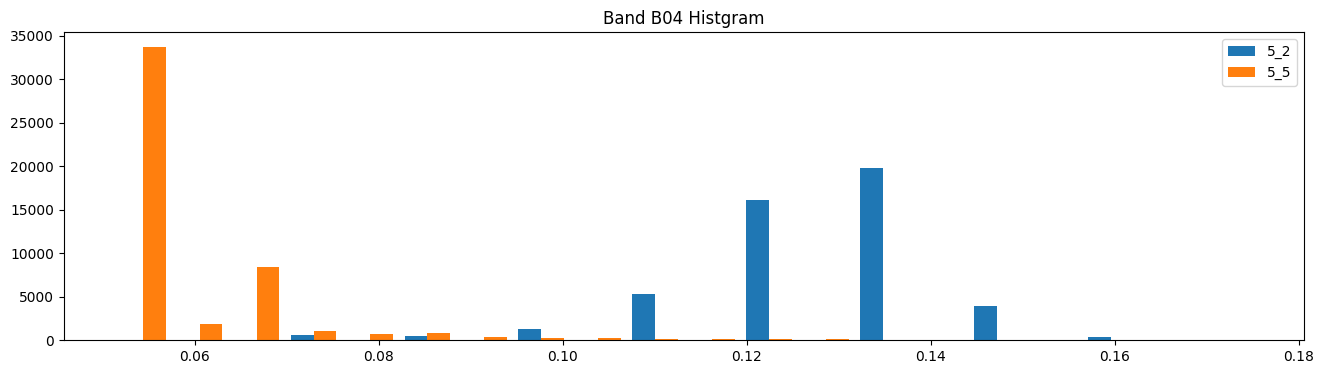

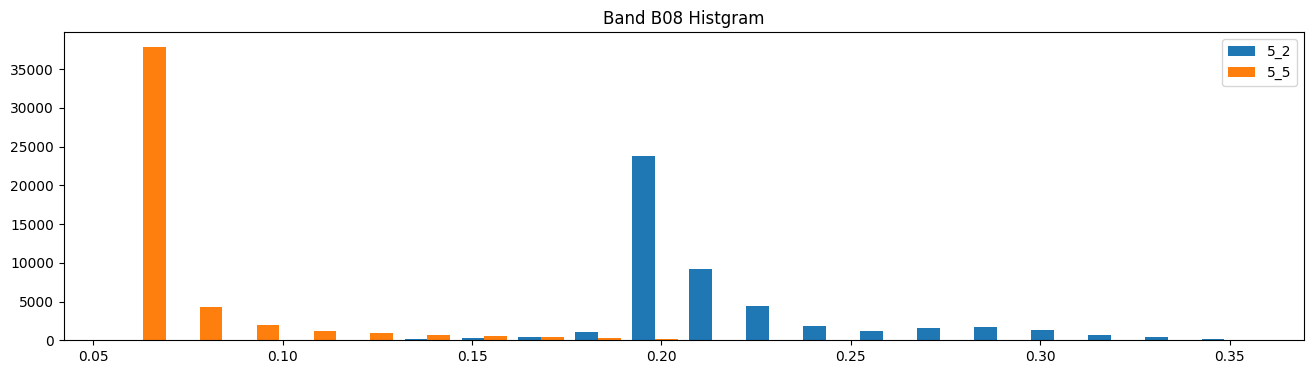

In [69]:
days, bands = ['5_2', '5_5'], ['B02', 'B03', 'B04', 'B08']

for band in bands:

  # 可視化設定
  plt.figure(figsize=(16, 4))
  plt.title(f'Band {band} Histgram')

  features = []

  for day in days:

    # I/O
    PATH_IMG = f'./data/{day}/{band}_cut.jp2'
    img = cv2.imread(PATH_IMG).astype(np.float32)

    # 前処理
    img = img / img.max()
    img = cv2.resize(img, (3866, 7356)) 

    # 特徴取得
    img_fire = img[np.where(mask == 1., True, False)]
    features.append(img_fire.flatten())

  # 日付比較で可視化
  plt.hist(features, bins=20, label=days)
  plt.legend()
  # 保存
  plt.savefig(f'hist_{band}.png')
  plt.show();
  plt.clf()
  plt.close()

上記の結果を見ると 閾値 `0.06 ~ 0.1` あたりの分離でもかなり精度良い予測ができそうですが、今回はお遊びなので

## モデリング
特徴はかなりわかりやすくデータも多少あるので CNN ベースの UNet で火事確率を予測するモデルを作成します

まずは (128, 128) のパッチに切り取っていきます

In [94]:
IMG_SIZE = 128
features = []
for band in bands:
  for day in days:
    # I/O
    PATH_IMG = f'./data/{day}/{band}_cut.jp2'
    img = cv2.imread(PATH_IMG, cv2.IMREAD_UNCHANGED).astype(np.float32)

    # 前処理
    img = img / img.max()
    img = cv2.resize(img, (3866, 7356)) 
    features.append(img)

features.append(mask)

imgs = np.stack(features, axis=2) # Hight, Width, Channel:9

for h in range(7356 // IMG_SIZE):
  for w in range(3866 // IMG_SIZE):
    patch = imgs[h*IMG_SIZE:(h+1)*IMG_SIZE, w*IMG_SIZE:(w+1)*IMG_SIZE]

    if np.sum(patch[:,:, -1]) > 0:
      PATH_PATCH = f'data/patch_h{str(h).zfill(3)}_w{str(w).zfill(3)}_fire.npy'
    else:
      PATH_PATCH = f'data/patch_h{str(h).zfill(3)}_w{str(w).zfill(3)}_.npy'
    
    np.save(PATH_PATCH, patch)

del imgs
gc.collect()

22

パッチの可視化確認

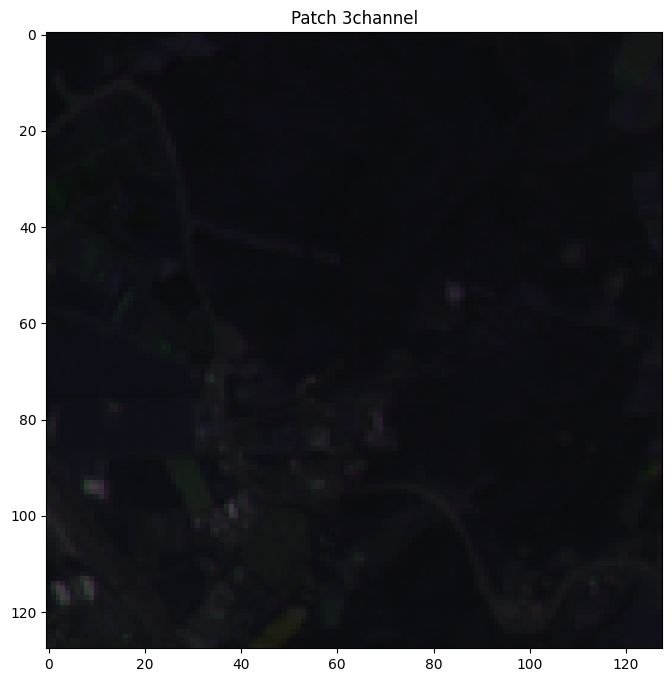

In [96]:
PATH_PATCH = './data/patch_h000_w000_.npy'
patch = np.load(PATH_PATCH)

plt.figure(figsize=(8, 8))
plt.title('Patch 3channel')
plt.imshow(patch[:, :, :3])
plt.savefig('patch.png')
plt.show();
plt.clf()
plt.close()

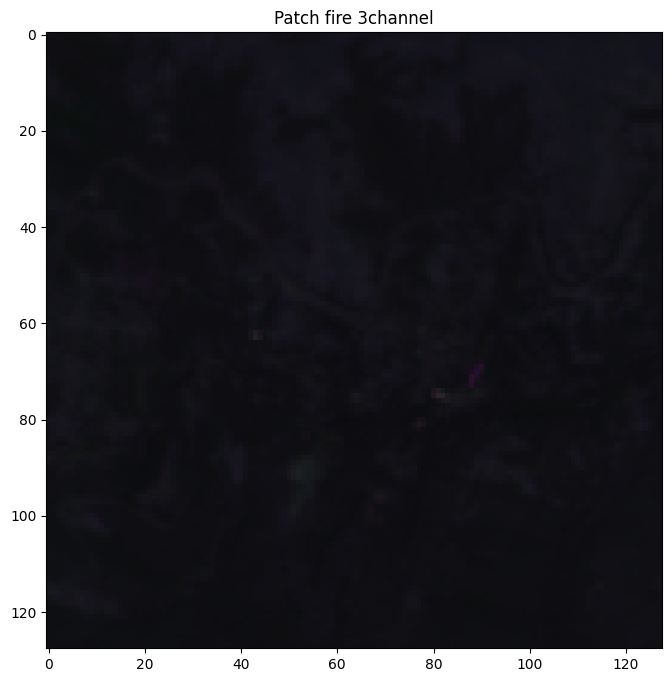

In [95]:
PATH_PATCH = './data/patch_h000_w014_fire.npy'
patch = np.load(PATH_PATCH)

plt.figure(figsize=(8, 8))
plt.title('Patch fire 3channel')
plt.imshow(patch[:, :, :3])
plt.savefig('patch_fire.png')
plt.show();
plt.clf()
plt.close()

学習のための準備

In [139]:
class DataTransform():
    def __init__(self):
        self.data_transform = {
            "train": A.Compose(
                [
                  A.HorizontalFlip(p=0.5),
                  A.VerticalFlip(p=0.5),
                  A.Transpose(p=0.5),
                  # A.Cutout(p=0.25),
                  ToTensorV2()
                ]
            ),
            "val": A.Compose(
                [
                  ToTensorV2(),
                ]
            )
        }

    def __call__(self, phase, img, anno_class_img):
        return self.data_transform[phase](image=img, mask=anno_class_img)

class FireDataset(Dataset):
    def __init__(self, img_list, phase, transform):
        self.img_list = img_list
        self.phase = phase
        self.transform = transform

    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, index):
        return self.pull_item(index)

    def pull_item(self, index):
        image_file_path = self.img_list[index]
        features = np.load(image_file_path)
        img, anno = features[:,:,:8], features[:,:,-1]
        
        img_and_anno = self.transform(self.phase, img, anno)
        img = img_and_anno["image"]
        anno = img_and_anno["mask"]

        return img, anno

In [140]:
PATHS_FIRE = glob.glob('data/*_fire.npy')
PATHS_SAFE = glob.glob('data/*_.npy')

print('Num Fire:', len(PATHS_FIRE), 'Num None:', len(PATHS_SAFE)) 

Num Fire: 5 Num None: 1710


In [141]:
# 不均衡比率 0.2923%
5 / 1710

0.0029239766081871343

## 学習と検証の分け方
今回は動作確認なので検証は学習の一部を利用

In [161]:
IDX_SPLIT, BATCH_SIZE = 128, 32
PATHS_TRAIN = PATHS_SAFE[IDX_SPLIT:]+ PATHS_FIRE
PATHS_VALID = PATHS_SAFE[:IDX_SPLIT] + PATHS_FIRE

train_dataset = FireDataset(PATHS_TRAIN, phase="train", transform=DataTransform())
val_dataset = FireDataset(PATHS_VALID, phase="val", transform=DataTransform())

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

dataloaders_dict = {"train": train_dataloader, "valid": val_dataloader}

## モデル作成

In [166]:
model = smp.Unet(
    encoder_name='timm-efficientnet-b0',
    encoder_weights='imagenet',
    in_channels=8,
    classes=1,
    activation=None,
)

# loss = smp.utils.losses.DiceLoss()
loss_fn = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam([dict(params=model.parameters(), lr=1e-4), ])

In [167]:
EPOCHS = 30
best_score = 1E5

train_loss = []
valid_loss = []

model = model.cuda()
os.makedirs("weights/", exist_ok=True) 

for i in range(0, EPOCHS):
  loss_epoch = []

  for phase in ['train', 'valid']:
    print(f'Epoch: {i} Phase {phase}')
    for (img, anno) in tqdm(dataloaders_dict[phase]):
      img, anno = img.cuda(), anno.cuda()

      if phase == 'train':
        model.train()
        output = model(img)
        loss = loss_fn(output.squeeze(dim=1), anno.squeeze(dim=1))
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        loss = loss.cpu().detach().numpy()
        
      else:
        with torch.no_grad():
          model.eval()
          output = model(img)
          loss = loss_fn(output.squeeze(dim=1), anno.squeeze(dim=1))
          loss = loss.cpu().numpy()

      loss_epoch.append(loss)

    if phase == 'train':
      train_loss.append(np.array(loss_epoch).mean())
    else:
      loss_mean = np.array(loss_epoch).mean()
      valid_loss.append(loss_mean)
      
      if best_score > loss_mean:
          best_score = loss_mean
          
          torch.save(model, os.path.join("weights/", 'best_model.pth'))

Epoch: 0 Phase train


100%|██████████| 50/50 [00:07<00:00,  6.50it/s]


Epoch: 0 Phase valid


100%|██████████| 5/5 [00:00<00:00, 17.31it/s]


Epoch: 1 Phase train


100%|██████████| 50/50 [00:07<00:00,  6.55it/s]


Epoch: 1 Phase valid


100%|██████████| 5/5 [00:00<00:00, 19.33it/s]


Epoch: 2 Phase train


100%|██████████| 50/50 [00:07<00:00,  6.50it/s]


Epoch: 2 Phase valid


100%|██████████| 5/5 [00:00<00:00, 21.17it/s]


Epoch: 3 Phase train


100%|██████████| 50/50 [00:07<00:00,  6.49it/s]


Epoch: 3 Phase valid


100%|██████████| 5/5 [00:00<00:00, 10.61it/s]


Epoch: 4 Phase train


100%|██████████| 50/50 [00:08<00:00,  5.65it/s]


Epoch: 4 Phase valid


100%|██████████| 5/5 [00:00<00:00, 15.59it/s]


Epoch: 5 Phase train


100%|██████████| 50/50 [00:08<00:00,  5.70it/s]


Epoch: 5 Phase valid


100%|██████████| 5/5 [00:00<00:00, 20.96it/s]


Epoch: 6 Phase train


100%|██████████| 50/50 [00:08<00:00,  6.01it/s]


Epoch: 6 Phase valid


100%|██████████| 5/5 [00:00<00:00, 16.75it/s]


Epoch: 7 Phase train


100%|██████████| 50/50 [00:08<00:00,  5.80it/s]


Epoch: 7 Phase valid


100%|██████████| 5/5 [00:00<00:00, 20.83it/s]


Epoch: 8 Phase train


100%|██████████| 50/50 [00:09<00:00,  5.21it/s]


Epoch: 8 Phase valid


100%|██████████| 5/5 [00:00<00:00, 17.58it/s]


Epoch: 9 Phase train


100%|██████████| 50/50 [00:09<00:00,  5.30it/s]


Epoch: 9 Phase valid


100%|██████████| 5/5 [00:00<00:00,  6.14it/s]


Epoch: 10 Phase train


100%|██████████| 50/50 [00:10<00:00,  4.92it/s]


Epoch: 10 Phase valid


100%|██████████| 5/5 [00:00<00:00, 21.19it/s]


Epoch: 11 Phase train


100%|██████████| 50/50 [00:07<00:00,  6.30it/s]


Epoch: 11 Phase valid


100%|██████████| 5/5 [00:00<00:00, 10.68it/s]


Epoch: 12 Phase train


100%|██████████| 50/50 [00:07<00:00,  6.37it/s]


Epoch: 12 Phase valid


100%|██████████| 5/5 [00:00<00:00, 16.01it/s]


Epoch: 13 Phase train


100%|██████████| 50/50 [00:08<00:00,  5.76it/s]


Epoch: 13 Phase valid


100%|██████████| 5/5 [00:00<00:00, 21.35it/s]


Epoch: 14 Phase train


100%|██████████| 50/50 [00:08<00:00,  6.20it/s]


Epoch: 14 Phase valid


100%|██████████| 5/5 [00:00<00:00, 20.70it/s]


Epoch: 15 Phase train


100%|██████████| 50/50 [00:08<00:00,  6.20it/s]


Epoch: 15 Phase valid


100%|██████████| 5/5 [00:00<00:00,  7.67it/s]


Epoch: 16 Phase train


100%|██████████| 50/50 [00:08<00:00,  5.90it/s]


Epoch: 16 Phase valid


100%|██████████| 5/5 [00:00<00:00, 14.73it/s]


Epoch: 17 Phase train


100%|██████████| 50/50 [00:08<00:00,  5.86it/s]


Epoch: 17 Phase valid


100%|██████████| 5/5 [00:00<00:00, 20.17it/s]


Epoch: 18 Phase train


100%|██████████| 50/50 [00:07<00:00,  6.34it/s]


Epoch: 18 Phase valid


100%|██████████| 5/5 [00:00<00:00, 14.98it/s]


Epoch: 19 Phase train


100%|██████████| 50/50 [00:09<00:00,  5.51it/s]


Epoch: 19 Phase valid


100%|██████████| 5/5 [00:00<00:00, 21.32it/s]


Epoch: 20 Phase train


100%|██████████| 50/50 [00:07<00:00,  6.42it/s]


Epoch: 20 Phase valid


100%|██████████| 5/5 [00:00<00:00, 15.56it/s]


Epoch: 21 Phase train


100%|██████████| 50/50 [00:10<00:00,  4.71it/s]


Epoch: 21 Phase valid


100%|██████████| 5/5 [00:00<00:00, 10.75it/s]


Epoch: 22 Phase train


100%|██████████| 50/50 [00:09<00:00,  5.24it/s]


Epoch: 22 Phase valid


100%|██████████| 5/5 [00:00<00:00, 20.83it/s]


Epoch: 23 Phase train


100%|██████████| 50/50 [00:08<00:00,  5.92it/s]


Epoch: 23 Phase valid


100%|██████████| 5/5 [00:00<00:00, 15.25it/s]


Epoch: 24 Phase train


100%|██████████| 50/50 [00:08<00:00,  5.82it/s]


Epoch: 24 Phase valid


100%|██████████| 5/5 [00:00<00:00, 15.51it/s]


Epoch: 25 Phase train


100%|██████████| 50/50 [00:09<00:00,  5.47it/s]


Epoch: 25 Phase valid


100%|██████████| 5/5 [00:00<00:00, 20.50it/s]


Epoch: 26 Phase train


100%|██████████| 50/50 [00:09<00:00,  5.37it/s]


Epoch: 26 Phase valid


100%|██████████| 5/5 [00:00<00:00, 20.91it/s]


Epoch: 27 Phase train


100%|██████████| 50/50 [00:07<00:00,  6.43it/s]


Epoch: 27 Phase valid


100%|██████████| 5/5 [00:00<00:00, 17.09it/s]


Epoch: 28 Phase train


100%|██████████| 50/50 [00:07<00:00,  6.45it/s]


Epoch: 28 Phase valid


100%|██████████| 5/5 [00:00<00:00, 20.61it/s]


Epoch: 29 Phase train


100%|██████████| 50/50 [00:08<00:00,  5.82it/s]


Epoch: 29 Phase valid


100%|██████████| 5/5 [00:00<00:00, 18.41it/s]


## 学習指標の推移

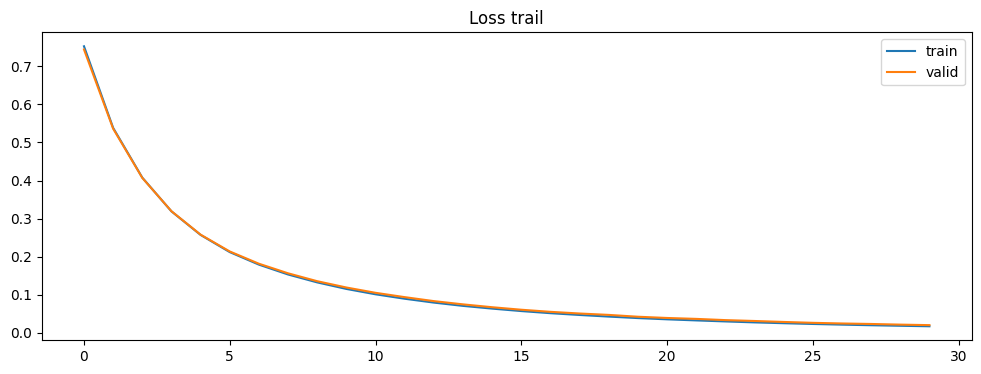

In [168]:
plt.figure(figsize=(12, 4))
plt.title('Loss trail')
plt.plot(np.array(train_loss), label='train')
plt.plot(np.array(valid_loss), label='valid')
plt.legend()
plt.savefig('loss.png')
plt.show();
plt.clf()
plt.close()

## 結果の可視化

0it [00:00, ?it/s]

Loss: 0.18385766446590424


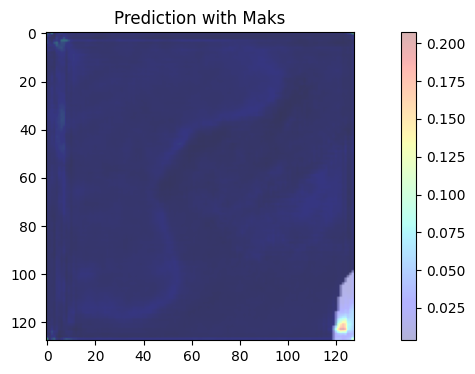

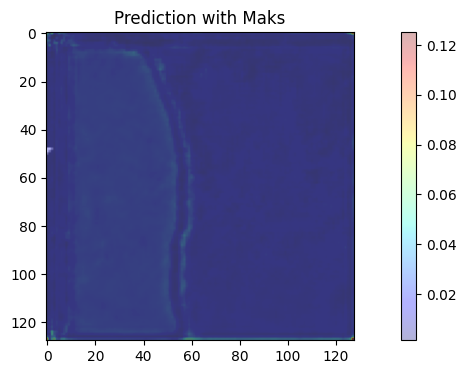

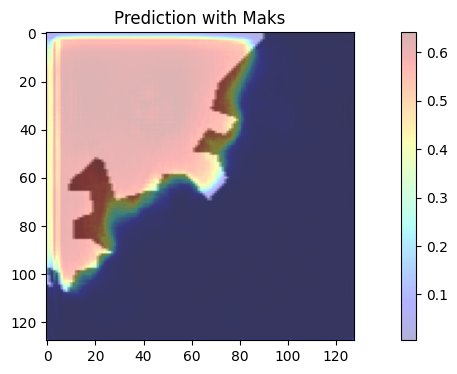

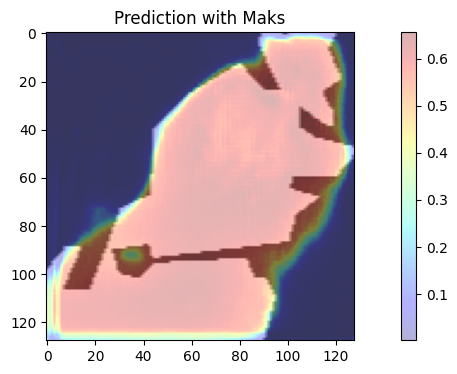

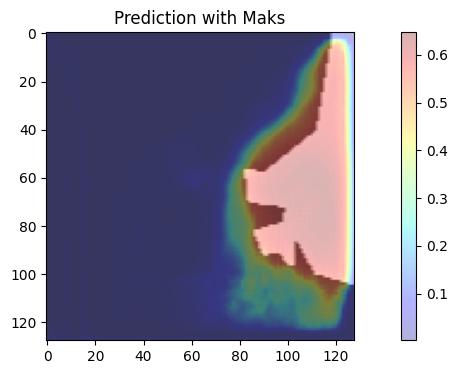

1it [00:02,  2.27s/it]


In [180]:
test_dataset = FireDataset(PATHS_FIRE, phase="val", transform=DataTransform())
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

model.eval()
for i, (img, anno) in tqdm(enumerate(test_dataloader)):
  with torch.no_grad():
      img, anno = img.cuda(), anno.cuda()
      output = model(img)
      output, anno = output.squeeze(dim=1), anno.squeeze(dim=1)
      loss = loss_fn(output, anno)
      preds = torch.sigmoid(output)
      loss = loss.cpu().numpy()
      print(f"Loss: {loss}")

      for pred, an in zip(preds.cpu().numpy(), anno.cpu().numpy()):
        plt.figure(figsize=(12, 4))
        plt.title('Prediction with Maks')
        plt.imshow(an, alpha=0.7, cmap='gray')
        plt.imshow(pred, cmap='jet', alpha=0.3)
        plt.colorbar()
        plt.show();
plt.clf()
plt.close()